## Предсказание ухода игроков в онлайн-игре на платформе iOs

Даны данные о сессиях игроков и о самих игроках. Нужно решить несколько задач, связанных предсказанием возможного ухода игроков.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline  

Загрузим данные:

In [2]:
data = pd.read_csv('practice_sessions_ios.csv', sep='|', names=['id', 'session_number', 'session_length',
                                                                'session_start_time', 'session_end_time', 'actdate'])
data['actdate'] = pd.to_datetime(data['actdate'])

In [3]:
data.head()

,id,session_number,session_length,session_start_time,session_end_time,actdate
0,00e954a1b3,12.0,29,1486997200,1486997229,2017-02-13
1,028498cd03,1.0,445,1485039376,1485039821,2017-01-21
2,12ab1dfa82,8.0,0,1486756815,1486756815,2017-02-10
3,0a0a1ffe3b,5.0,2846,1484976494,1484979340,2017-01-21
4,01c68437aa,7.0,1610,1484329332,1484330942,2017-01-13


# Overview

Перед тем, как приступить к предсказанию, немного посмотрим, что представляют из себя данные:

**Распределение количества сессий по дням:**

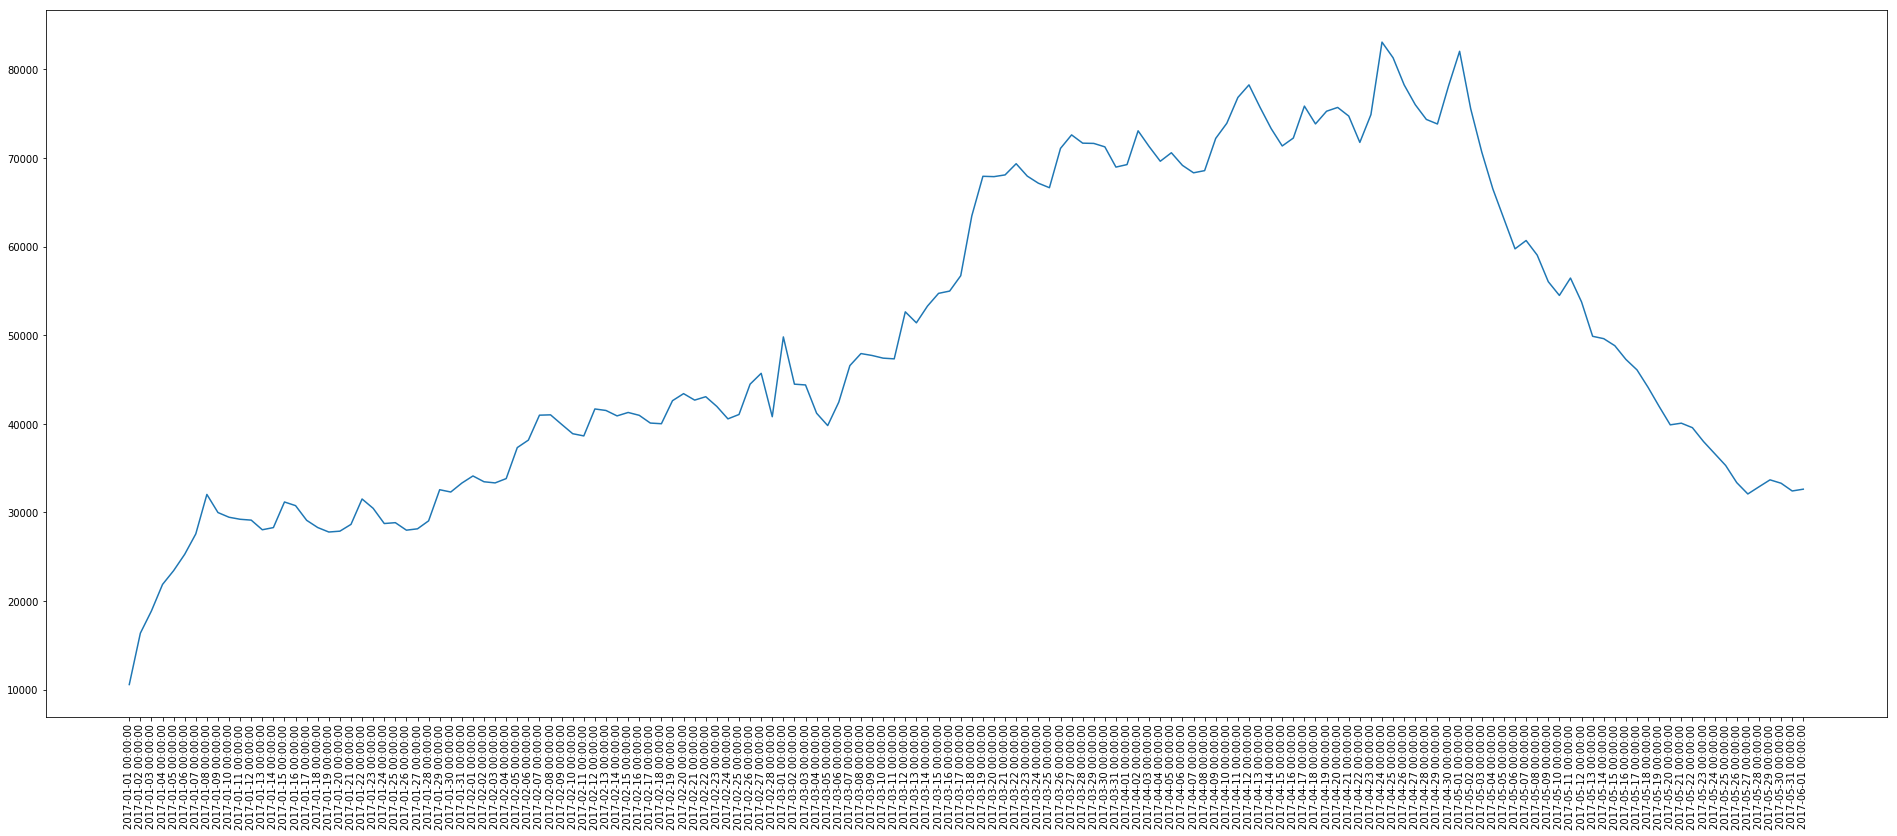

In [4]:
sessions_per_day = data[['actdate', 'id']].groupby('actdate').count().reset_index().rename(columns={'id':'count_sessions'})

fig = plt.figure(figsize=(33, 13))
plt.plot(sessions_per_day[['count_sessions']].values)
plt.xticks(np.arange(sessions_per_day.shape[0]), [datetime.utcfromtimestamp(date.tolist()/1e9) for date in sessions_per_day['actdate'].values], rotation=90);

Так как до определенного момента наблюдался почти постоянный рост количества сессий, брать топ 10% дней и смотреть на их дни недели неразумно, так что посмотрим на пики (чтоб проверить теорию, что больше всего играют по выходным):

Пики по дням недели:

In [5]:
from scipy.signal import argrelextrema
import calendar

peaks = sessions_per_day['actdate'][argrelextrema(sessions_per_day[['count_sessions']].values, np.greater)[0]].values
peak_days = [calendar.day_name[datetime.utcfromtimestamp(date.tolist()/1e9).weekday()] for date in peaks]
pd.DataFrame(peak_days)[0].value_counts()

Wednesday    10
Sunday       10
Monday        7
Thursday      2
Name: 0, dtype: int64

**Распределение числа уникальных пользователей в игре по дням:**

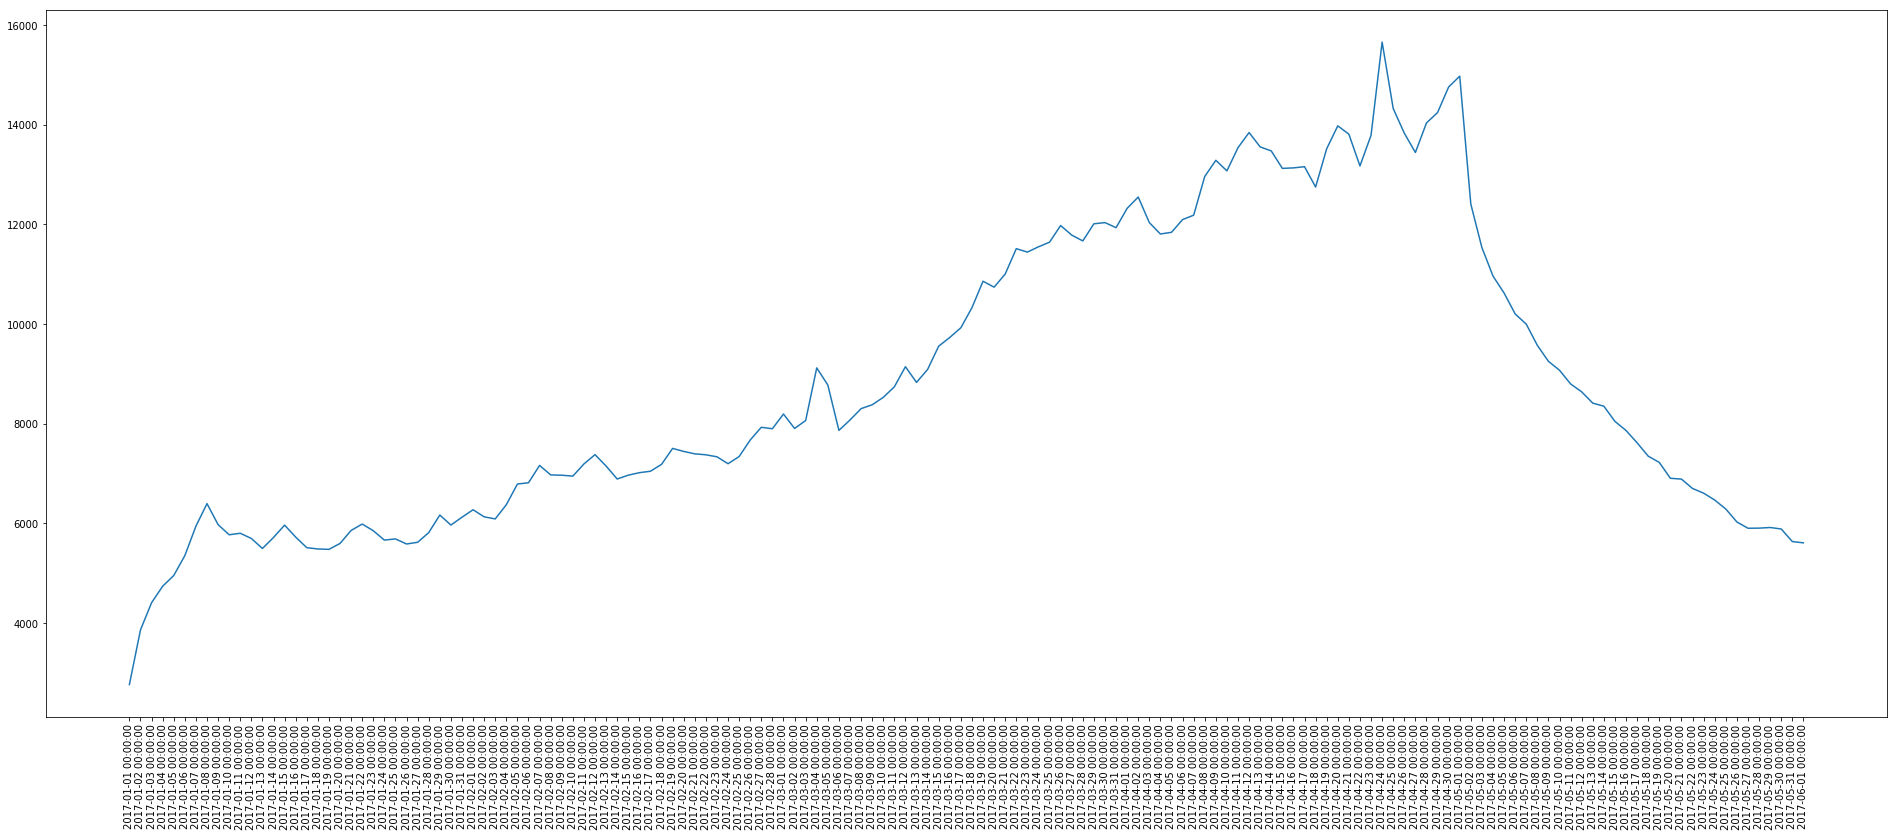

In [6]:
players_per_day = data.groupby(['actdate', 'id']).count().reset_index()[['actdate', 'id']].groupby('actdate').count().reset_index().rename(columns={'id':'count_players'})

fig = plt.figure(figsize=(33, 13))
plt.plot(players_per_day[['count_players']].values)
plt.xticks(np.arange(players_per_day.shape[0]), [datetime.utcfromtimestamp(date.tolist()/1e9) for date in players_per_day['actdate'].values], rotation=90);

In [7]:
peaks = players_per_day['actdate'][argrelextrema(players_per_day[['count_players']].values, np.greater)[0]].values
peak_days = [calendar.day_name[datetime.utcfromtimestamp(date.tolist()/1e9).weekday()] for date in peaks]
pd.DataFrame(peak_days)[0].value_counts()

Sunday       11
Wednesday     6
Monday        5
Thursday      2
Tuesday       1
Saturday      1
Name: 0, dtype: int64

**Распределение регистрации новых пользователей по дням:**

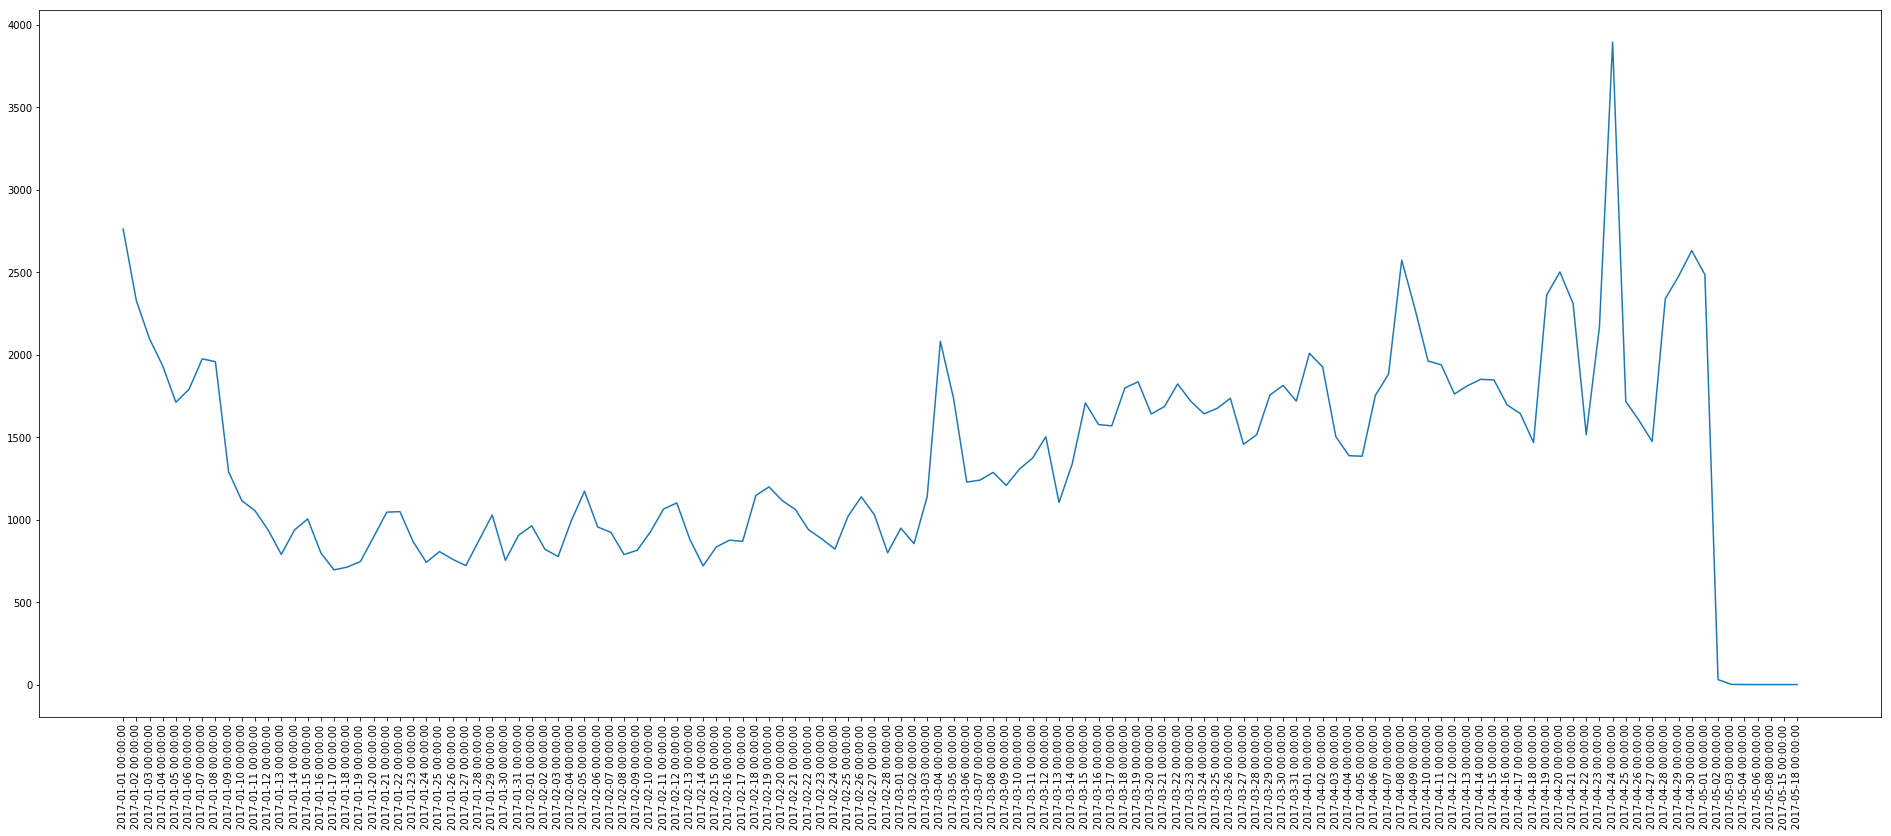

In [8]:
first_appearances = data[['id', 'actdate']].sort_values('actdate').groupby(['id']).first().reset_index()
first_appearances.columns = ['id', 'first_appearance']
growth_by_day = first_appearances.reset_index().groupby('first_appearance').count().reset_index().rename(columns={'id':'count_new_players'})

fig = plt.figure(figsize=(33, 13))
plt.plot(growth_by_day[['count_new_players']].values)
plt.xticks(np.arange(growth_by_day.shape[0]), [datetime.utcfromtimestamp(date.tolist()/1e9) for date in growth_by_day['first_appearance'].values], rotation=90);

In [9]:
peaks = growth_by_day['first_appearance'][argrelextrema(growth_by_day[['count_new_players']].values, np.greater)[0]].values
peak_days = [calendar.day_name[datetime.utcfromtimestamp(date.tolist()/1e9).weekday()] for date in peaks]
pd.DataFrame(peak_days)[0].value_counts()

Sunday       11
Wednesday     6
Saturday      4
Thursday      3
Monday        1
Friday        1
Name: 0, dtype: int64

Основываясь на полученные данные о пиках, можно сказать, что больше всего играют в выходные, а так же в середине недели, в среду.

# Prediction

Задача - по данным игроков за первые 30 дней, проведенных ими в игре, предсказать, сколько дней они проведут в следующие 2 недели. Сначала предскажем, останется ли человек вообще (останется = проведет 3 дня или больше), далее, если останется, займемся предсказанием количеством дней.

Подготовим данные. Нужно получить таблицу с одной строкой для каждого игрока и с 30-ю столбцами, в n-м из которых указано число сессий, проведенных в игроком в n-й с момента его регистрации день, потом уже генерировать остальные признаки.

In [10]:
from datetime import timedelta
data = data.merge(first_appearances, on='id', how='left')
pred_data = data[data['actdate']<data['first_appearance']+timedelta(days=30)]

Последний день, о сессиях которого имеется информация - 1 июня. Так как необходимо, чтобы в обучающей и тестовой выборке были игроки, которые уже провели в игре 44 дня, удалим всех игроков, проведших в игре меньше:

In [11]:
valid_players = data[data['first_appearance'] < '2017-04-14']

Оставим информацию только о сессиях, проведенных менее, чем через 30 дней с момента регистрации:

In [12]:
valid_players = valid_players[valid_players['actdate'] < valid_players['first_appearance'] + timedelta(days=30)]

Число сессий по дням для каждого из оставшихся игроков:

In [13]:
valid_players = valid_players.sort_values(['id', 'actdate']).groupby(['id', 'actdate']).count()[['session_length']].reset_index().rename(columns={'session_length':'count_sessions'})

К информации о каждом из дней добавим порядковый номер дня с момента регистрации игрока:

In [14]:
valid_players = valid_players.merge(first_appearances, on='id', how='left')
valid_players['day_num'] = valid_players['actdate'] - valid_players['first_appearance']
valid_players = valid_players.drop('first_appearance', axis=1)

In [15]:
valid_players = pd.get_dummies(valid_players, columns=['day_num']).drop(['actdate'], axis=1)
ids = valid_players['id']
valid_players = valid_players[valid_players.columns[1:]].mul(valid_players[valid_players.columns[1:]].pop('count_sessions').values, axis=0).drop('count_sessions', axis=1)
valid_players['id'] = ids
valid_players = valid_players.groupby('id').agg('sum').reset_index()
valid_players = valid_players.merge(first_appearances, on='id', how='left')

In [16]:
valid_players.columns.values[1:31] = np.array(['day_num_%d' % c for c in range(0,30)])

Получилось то, что нужно (признак *day_num_n* - количество сессий, проведенных игроков на **n**-й день после регистрации в игре):

In [17]:
valid_players.head()

,id,day_num_0,day_num_1,day_num_2,day_num_3,day_num_4,day_num_5,day_num_6,day_num_7,day_num_8,...,day_num_21,day_num_22,day_num_23,day_num_24,day_num_25,day_num_26,day_num_27,day_num_28,day_num_29,first_appearance
0,000192edb1,6,4,8,4,5,3,1,0,0,...,0,0,0,0,0,0,0,0,0,2017-01-31
1,0001a94437,3,3,4,3,2,1,9,1,6,...,0,0,0,0,0,0,0,0,0,2017-03-11
2,00028007b9,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2017-03-30
3,000303d57f,4,1,0,1,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,2017-01-26
4,00054738b4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2017-04-08


Аналогичную таблицу для удобства сделаем и для количества времени, проведенного в игре:

In [18]:
valid_players_length = data[data['first_appearance'] < '2017-04-14']
valid_players_length = valid_players_length[valid_players_length['actdate'] < valid_players_length['first_appearance'] + timedelta(days=30)]
valid_players_length = valid_players_length.sort_values(['id', 'actdate']).groupby(['id', 'actdate']).sum()[['session_length']].reset_index().rename(columns={'session_length':'count_sessions'})
valid_players_length = valid_players_length.merge(first_appearances, on='id', how='left')
valid_players_length['day_num'] = valid_players_length['actdate'] - valid_players_length['first_appearance']
valid_players_length = valid_players_length.drop('first_appearance', axis=1)
valid_players_length = pd.get_dummies(valid_players_length, columns=['day_num']).drop(['actdate'], axis=1)
ids = valid_players_length['id']
valid_players_length = valid_players_length[valid_players_length.columns[1:]].mul(valid_players_length[valid_players_length.columns[1:]].pop('count_sessions').values, axis=0).drop('count_sessions', axis=1)
valid_players_length['id'] = ids
valid_players_length = valid_players_length.groupby('id').agg('sum').reset_index()
valid_players_length = valid_players_length.merge(first_appearances, on='id', how='left')
valid_players_length.columns.values[1:31] = np.array(['day_num_%d_length' % c for c in range(0,30)])

In [19]:
res = valid_players_length.copy().drop('first_appearance', axis=1)
del valid_players_length

In [20]:
res.head()

,id,day_num_0_length,day_num_1_length,day_num_2_length,day_num_3_length,day_num_4_length,day_num_5_length,day_num_6_length,day_num_7_length,day_num_8_length,...,day_num_20_length,day_num_21_length,day_num_22_length,day_num_23_length,day_num_24_length,day_num_25_length,day_num_26_length,day_num_27_length,day_num_28_length,day_num_29_length
0,000192edb1,2596,1555,1871,741,1425,1041,358,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0001a94437,3707,3807,1664,951,2107,150,4133,120,1358,...,0,0,0,0,0,0,0,0,0,0
2,00028007b9,30,89,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000303d57f,1296,1409,0,688,0,1468,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00054738b4,1566,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Классификация

Найдем для каждого из игроков число дней, проведенных в течение 2-х недели после первых 30-ти дней:

In [21]:
y = data[(data['actdate'] > data['first_appearance'] + timedelta(days=30)) & (data['actdate'] < data['first_appearance'] + timedelta(days=45))]
y = y.groupby(['id', 'actdate']).count().reset_index().groupby('id').count().reset_index()[['id', 'actdate']]
y.columns = ['id', 'y']

(Здесь и далее значение целевой переменной 1 = человек останется в игре, 0 - отвалится)

In [22]:
valid_players = valid_players.merge(y, on='id', how='left')
valid_players['y'] = valid_players['y'].fillna(0)

Необходимо определиться, в каком случае мы будем считать, что человек останется. Посмотрим на распределение дней, которые люди провели в игре в течение прогнозируемого периода, при условии, что этих дней больше нуля:

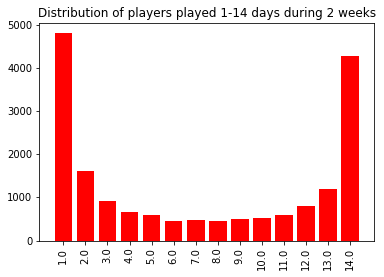

In [23]:
n_days = pd.DataFrame(valid_players[valid_players['y'] > 0]['y'].value_counts()).reset_index().rename(columns={'index':'n_days', 'y':'n_players'}).sort_values('n_days')
plt.bar(range(n_days.shape[0]), n_days['n_players'].values,
       color="r", align="center")
plt.xticks(range(n_days.shape[0]), n_days['n_days'].values, rotation=90);
plt.title('Distribution of players played 1-14 days during 2 weeks');

Видно, что много человек играют один день и пропадают. Число людей, проведших только 2 дня из возможных 14-ти, тоже выше среднего, так что предлагается не считать и этих людей остающимися.

Итак, человек останется, если проведет в игре 3 или больше дней:

In [24]:
valid_players['will_stay'] = (valid_players['y'] > 2).astype(int)
pred_df = valid_players.copy()

На всякий случай визуализируем часть данных при помощи t-SNE:

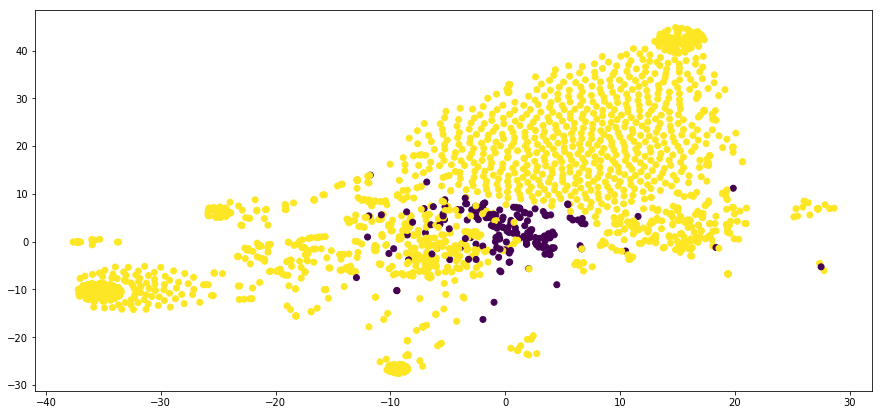

In [23]:
from sklearn.manifold import TSNE
viz = TSNE().fit_transform(valid_players[valid_players.columns[1:-3]].values[:2000])
fig = plt.figure(figsize=(15, 7))
plt.scatter(viz[:,0], viz[:,1], c=(valid_players['y'].values[:2000] < 3).astype(int));

Добавим признаков (предварительно загрузив дополнительные таблицы):

In [25]:
dau = pd.read_csv('practice_dau_ios.csv', sep='|', names=['id', 'country', 'pgr', 'actdate'])
dau['actdate'] = pd.to_datetime(dau['actdate'])
dau = dau.merge(first_appearances, on='id', how='left')

In [26]:
pact = pd.read_csv('practice_pact_ios.csv', sep='|', names=['id', 'actdate', 'regdate', 'clusters_ml_ended', 'revenue',
                        'transactions', 'quests_end', 'm_quests_end', 'crystals_value_spend', 'store_enters'])
pact['actdate'] = pd.to_datetime(pact['actdate'])
pact = pact.merge(first_appearances, on='id', how='left')

1. Были добавлены признаки, агрегирующие выше описанные по нескольким типам периодов. Первый - по всем 30-ти дням (**среднеквадратическое отклонение**), второй - по неделям (**среднеквадратическое отклонение в 24-30 дни и 17-23**)
2. Помимо количества сессий, важна и их длина, так как при прочих равных более заинтересованным в игре логично считать игрока, проводящего больше. Поэтому были добавлены признаки **средняя длина одной сессии** и **среднеквадратическое отклонение длины одной сессии**.
3. Чтобы количественно выразить динамику изменения игровой активности на начало и конец рассматриваемого периода, были введены признаки $\frac{\mbox{Среднее значение в первые 7 дней}}{\mbox{Среднее значение в последние 7 дней}}$.
4. **Общее количество pgr-сообщений**
5. Если человек вкладывает в игру деньги, это говорит о его намерении остаться на какой-то срок, так что был добавлен признак **сумма вложенных денежных средств**. Если из всей массы пользователей остаются 8.5\% пользователей, то знание того, что человек вкладывал в игру деньги, повышает эту вероятность в 3.7 раз (37.475\% человек, задонативших в первый месяц, оставались). Кроме того, когда дело доходит до предказания количества дней, в случае, если классификатор называет человека остающимся, знание, что он совершал покупки, повышает количество проведенных дней в среднем на 0.26 дня.

In [27]:
pred_df = valid_players.copy()
pred_df['sessions_std'] = pred_df[pred_df.columns[1:31]].std(axis=1)
pred_df['4week_sessions_std'] = pred_df[pred_df.columns[24:31]].std(axis=1)
pred_df['3week_sessions_std'] = pred_df[pred_df.columns[17:24]].std(axis=1)
pred_df['count_days_last_2_weeks'] = (pred_df[pred_df.columns[15:31]] > 0).sum(axis=1)
pred_df = pred_df.merge(pred_data.groupby(['id'])[['session_length']].std().reset_index().rename(columns={'session_length':'session_length_std'}), on='id', how='left')
pred_df = pred_df.merge(dau[dau['actdate']<dau['first_appearance']+timedelta(days=30)][['id','pgr']].groupby('id').sum().reset_index(), on='id', how='left')
pred_df = pred_df.merge(pact[pact['actdate']<pact['first_appearance']+timedelta(days=30)][['id', 'revenue']].groupby('id').sum().reset_index(), on='id', how='left')
pred_df['max_sessions_diff'] = valid_players[valid_players.columns[1:8]].max(axis=1)/(valid_players[valid_players.columns[24:31]].max(axis=1)+0.01)
pred_df = pred_df.merge(res[['id'] + res.columns[7:31].tolist()], on='id', how='left')
pred_df = pred_df.fillna(0)

Сделаем разделение по времени: в обучающей выборке игроки, начавшие играть раньше, чем игроки из тестовой (дата выбрана исходя из пропорции размер обучеющей:размер тестовой = примерно 4:1):

In [28]:
x_columns = pred_df.columns[1:31].tolist() + pred_df.columns[34:].tolist()
X_train = pred_df[pred_df['first_appearance'] < '2017-03-30'][x_columns].values
y_train = pred_df[pred_df['first_appearance'] < '2017-03-30'][pred_df.columns[33]].values
X_test = pred_df[pred_df['first_appearance'] >= '2017-03-30'][x_columns].values
y_test = pred_df[pred_df['first_appearance'] >= '2017-03-30'][pred_df.columns[33]].values

Обучим несколько моделей и сравним результаты:

**GradientBoostingClassifier**

Подберем гиперпараметры:

In [309]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [50,100,200,500,1000],
    'learning_rate': [0.01, 0.05, 0.1]
}

gr = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring='f1_micro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'n_estimators': 500, 'learning_rate': 0.01}


In [311]:
param_grid = {
    'max_depth':range(5,16,2),
    'min_samples_split':range(200,1001,200)
}
gr = GridSearchCV(GradientBoostingClassifier(learning_rate=0.01, n_estimators=500), param_grid, scoring='f1_micro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'max_depth': 5, 'min_samples_split': 800}


In [42]:
from sklearn.ensemble import GradientBoostingClassifier

model=GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,max_depth=5,min_samples_split=800)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ["Won't stay", "Will stay"]
print(classification_report(y_test, pred, target_names=target_names))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

 Won't stay       0.99      0.99      0.99     25842
  Will stay       0.87      0.84      0.85      1869

avg / total       0.98      0.98      0.98     27711

Confusion matrix:
 [[25599   243]
 [  296  1573]]


Т.к., как будет видно ниже, эта модель окажется одной из лучших, визуализируем важности признаков:

Top 10 features:
1. day_num_29 (0.209626)
2. day_num_29_length (0.120874)
3. day_num_28 (0.094517)
4. day_num_27_length (0.089545)
5. day_num_28_length (0.081823)
6. count_days_last_2_weeks (0.049708)
7. max_sessions_diff (0.029568)
8. 4week_sessions_std (0.024667)
9. pgr (0.024349)
10. day_num_24_length (0.023531)
11. sessions_std (0.022066)
12. day_num_25_length (0.016432)
13. day_num_26_length (0.014362)
14. day_num_23_length (0.011630)
15. day_num_22_length (0.011545)


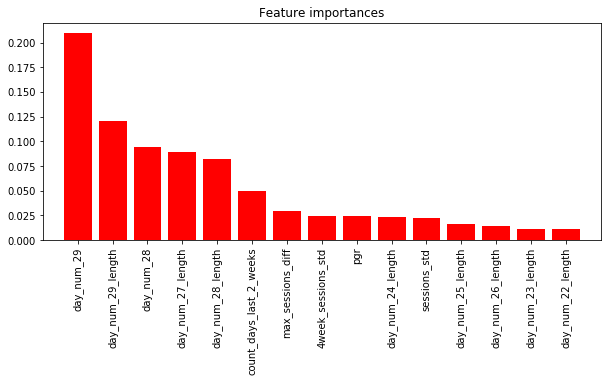

In [55]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Top 10 features:")
for f in range(15):
    print("%d. %s (%f)" % (f + 1, x_columns[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(10,4))
plt.title("Feature importances")
plt.bar(range(15), importances[indices][:15],
       color="r", align="center")
plt.xticks(range(15), np.array(x_columns)[indices][:15], rotation=90)
plt.xlim([-1, 15])
plt.show()

Т.к. гиперпараметры подбирались долго (много деревьев), а результат почти не менялся, я не стал подбирать остальные.

**CatBoostClassifier**

In [292]:
param_grid = {
    'learning_rate': [i/10.0 for i in range(0,5)],
    'l2_leaf_reg': [0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}

gr = GridSearchCV(CatBoostClassifier(), param_grid, scoring='f1_micro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'l2_leaf_reg': 100, 'learning_rate': 0.1}


In [211]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(l2_leaf_reg=100, learning_rate=0.1, auto_stop_pval=1e-10, eval_metric='Recall')
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [212]:
print(classification_report(y_test, pred, target_names=target_names))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

 Won't stay       0.99      0.99      0.99     25842
  Will stay       0.87      0.84      0.85      1869

avg / total       0.98      0.98      0.98     27711

Confusion matrix:
 [[25604   238]
 [  303  1566]]


**XGBClassifier**

In [243]:
param_grid_xgcl_1 = {
    'n_estimators':[50,100,200,500,1000]
}
gr = GridSearchCV(XGBClassifier(), param_grid_xgcl_1, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'n_estimators': 100}


In [242]:
param_grid_xgcl_2 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gr = GridSearchCV(XGBClassifier(), param_grid_xgcl_2, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'max_depth': 3, 'min_child_weight': 3}


In [251]:
param_grid_xgcl_3 = {
     'gamma':[i/10.0 for i in range(0,5)],
     'learning_rate': [i/10.0 for i in range(1,5)]
}
gr = GridSearchCV(XGBClassifier(max_depth=3, min_child_weight=3), param_grid_xgcl_3, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'gamma': 0.2, 'learning_rate': 0.1}


In [252]:
param_grid_xgcl_4 = {
     'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}
gr = GridSearchCV(XGBClassifier(max_depth=3, min_child_weight=3, gamma=0.2, learning_rate=0.1), param_grid_xgcl_4, 
                  scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'reg_alpha': 0.01}


In [253]:
param_grid_xgcl_5 = {
    'subsample':[i/10.0 for i in range(1,11)],
    'colsample_bytree':[i/10.0 for i in range(1,11)]
}
gr = GridSearchCV(XGBClassifier(max_depth=3, min_child_weight=3, gamma=0.2, learning_rate=0.1, reg_alpha=0.01), 
                  param_grid_xgcl_5, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'subsample': 0.5, 'colsample_bytree': 0.7}


In [56]:
from xgboost import XGBClassifier
cl = XGBClassifier(max_depth=3, min_child_weight=3, gamma=0.2, learning_rate=0.1, reg_alpha=0.01, subsample=0.5,
                   colsample_bytree=0.7)
cl.fit(X_train, y_train)
pred = cl.predict(X_test)

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ["Won't stay", "Will stay"]
print(classification_report(y_test, pred, target_names=target_names))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

 Won't stay       0.99      0.99      0.99     25842
  Will stay       0.88      0.83      0.85      1869

avg / total       0.98      0.98      0.98     27711

Confusion matrix:
 [[25620   222]
 [  312  1557]]


Оценим важность признаков в полученной модели **xgboost**:

Top 10 features:
1. count_days_last_2_weeks (0.109399)
2. pgr (0.100154)
3. max_sessions_diff (0.058552)
4. day_num_29_length (0.047766)
5. day_num_29 (0.040062)
6. 4week_sessions_std (0.036980)
7. day_num_28_length (0.035439)
8. sessions_std (0.035439)
9. day_num_27_length (0.026194)
10. session_length_std (0.026194)


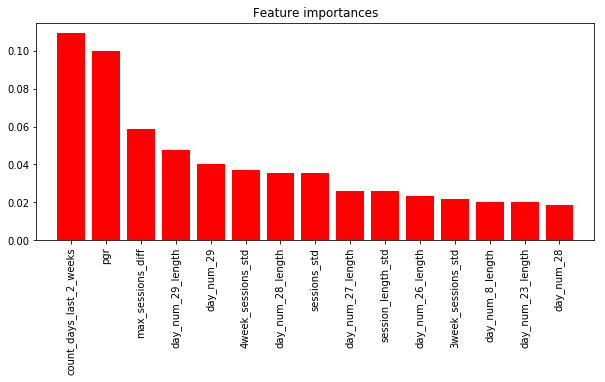

In [59]:
importances = cl.feature_importances_
indices = np.argsort(importances)[::-1]
print("Top 10 features:")
for f in range(10):
    print("%d. %s (%f)" % (f + 1, x_columns[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(10,4))
plt.title("Feature importances")
plt.bar(range(15), importances[indices][:15],
       color="r", align="center")
plt.xticks(range(15), np.array(x_columns)[indices][:15], rotation=90)
plt.xlim([-1, 15])
plt.show()

Ожидаемо, наибольшую важность имеют признаки, характеризующие количество сессий в последние дни наблюдаемого периода (особенно в 2 последних), так как если человек до сих пор продолжает играть в 26-27-28-29 дни, вероятность того, что он и впредь продолжит играть, сильно повышается, а так же сгенерированные признаки. В отличие от GradientBoostingClassifier, который сильнее всего ориентировался на сессии в последний день наблюдаемого периода, xgboost в первую очередь смотрел на информацию о времени. В xgboost есть несколько метрик измерения важности, на всякий случай отмечу, что я сравнивал по тем же самым.

В целом, результат по разным моделям получился примерно одинаковым.

-----------------------------------------------
Попробуем модель **PCA + xgboost**:

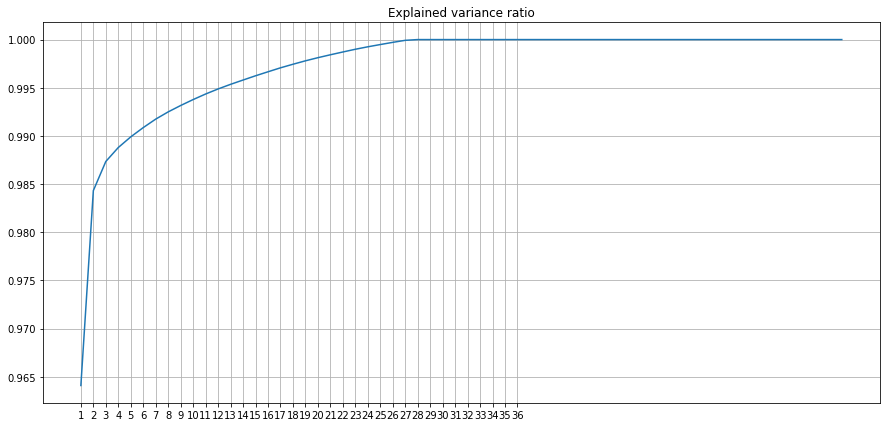

In [60]:
from sklearn.decomposition import PCA
plt.figure(figsize=(15,7))
plt.plot(PCA().fit(X_train).explained_variance_ratio_.cumsum())
plt.title('Explained variance ratio')
plt.xticks(list(range(0,36)), list(range(1,37)));
plt.grid()

Излом при n=4

In [67]:
pca = PCA(n_components=4)
X_train_tr = pca.fit_transform(X_train)
X_test_tr = pca.transform(X_test)

In [68]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train_tr, y_train)
pred = model.predict(X_test_tr)

In [69]:
print(classification_report(y_test, pred, target_names=target_names))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

 Won't stay       0.98      0.98      0.98     25842
  Will stay       0.79      0.79      0.79      1869

avg / total       0.97      0.97      0.97     27711

Confusion matrix:
 [[25454   388]
 [  390  1479]]


## Регрессия

Для тех, кто останется, предскажем количество дней, которое они проведут в игре в следующие две недели::

In [29]:
regr_data = pred_df[pred_df['will_stay'] == 1].drop(['will_stay'], axis=1)

In [30]:
x_columns = regr_data.columns.tolist()[1:31] + regr_data.columns[33:].tolist()
X_train = regr_data[regr_data['first_appearance'] < '2017-03-30'][x_columns].values
y_train = regr_data[regr_data['first_appearance'] < '2017-03-30'][regr_data.columns[32]].values
X_test = regr_data[regr_data['first_appearance'] >= '2017-03-30'][x_columns].values
y_test = regr_data[regr_data['first_appearance'] >= '2017-03-30'][regr_data.columns[32]].values

Попробуем **CatBoost**:

In [259]:
param_grid = {
    'learning_rate': [i/10.0 for i in range(0,5)],
    'l2_leaf_reg': [0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}

gr = GridSearchCV(CatBoostRegressor(), param_grid, scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'l2_leaf_reg': 0.01, 'learning_rate': 0.1}


In [145]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
model = CatBoostRegressor(l2_leaf_reg=0.01, learning_rate=0.1, auto_stop_pval=1e-10, eval_metric='MAE')
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %0.4f\nr2: %0.4f\nRMSE: %0.4f' % (mean_absolute_error(pred, y_test), r2_score(y_test, pred),
                                       np.sqrt(mean_squared_error(y_test, pred))))

MAE: 2.4486
r2: 0.3544
RMSE: 3.1882


Попробуем **xgboost**:

In [53]:
from xgboost import XGBRegressor

In [62]:
param_grid_xgreg_1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'n_estimators':np.arange(100,1000,200)
}

gr = GridSearchCV(XGBRegressor(), param_grid_xgreg_1, scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'min_child_weight': 3, 'n_estimators': 100, 'max_depth': 5}


In [63]:
param_grid_xgreg_2 = {
    'gamma':[i/10.0 for i in range(0,5)],
    'learning_rate': [i/10.0 for i in range(0,5)]
}
gr = GridSearchCV(XGBRegressor(max_depth=7, min_child_weight=1), param_grid_xgreg_2, scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'gamma': 0.1, 'learning_rate': 0.1}


In [72]:
param_grid_xgreg_3 = {
    'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}
gr = GridSearchCV(XGBRegressor(max_depth=7, min_child_weight=1, gamma=0.3, learning_rate=0.1), param_grid_xgreg_3, 
                  scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'reg_alpha': 1e-5}


In [65]:
param_grid_xgreg_4 = {
    'subsample':[i/10.0 for i in range(1,11)],
    'colsample_bytree':[i/10.0 for i in range(1,11)]
}
gr = GridSearchCV(XGBRegressor(max_depth=7, min_child_weight=1, gamma=0.3, learning_rate=0.1, reg_alpha=10),
                  param_grid_xgreg_4, scoring='neg_mean_absolute_error')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'colsample_bytree': 1.0, 'subsample': 1.0}


In [31]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = XGBRegressor(max_depth=5, min_child_weight=3, gamma=0.1, learning_rate=0.1, reg_alpha=1e-05, subsample=1,
                     colsample_bytree=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %0.4f\nr2: %0.4f\nRMSE: %0.4f' % (mean_absolute_error(pred, y_test), r2_score(y_test, pred),
                                              np.sqrt(mean_squared_error(y_test, pred))))

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


MAE: 2.4283
r2: 0.3666
RMSE: 3.1579


Отобразим распределение величин ошибок:

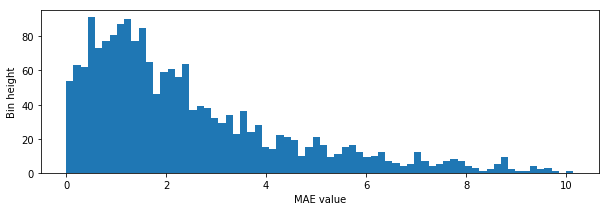

In [32]:
fig = plt.figure(figsize=(10,3))
plt.hist(abs(y_test-pred), bins=70, label='Distribution of absolute errors');
plt.xlabel('MAE value')
plt.ylabel('Bin height')

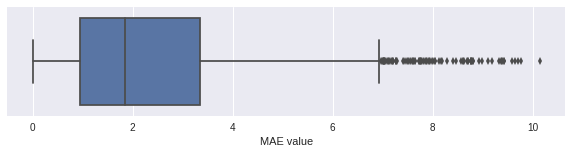

In [33]:
import seaborn as sn
fig = plt.figure(figsize=(10, 2))
sn.boxplot(abs(y_test-pred))
plt.xlabel('MAE value')

Оценим важность признаков: (f0-f29 - дни 0-29)

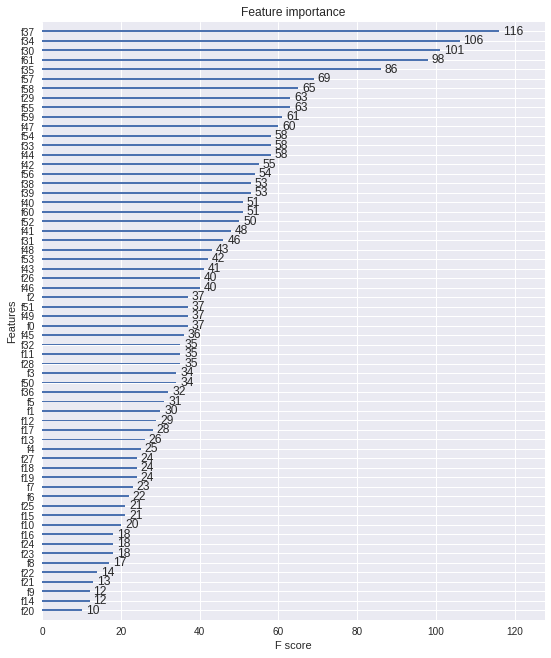

In [35]:
from xgboost import plot_importance
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(9, 11)

Видно, что наиболее часто разбиение в деревьях происходило как раз по сгенерированным признакам, т.е. они оказались полезными, а наиболее важное значение имеют характеристики, связанные со временем, проводимым в игре за день день.

In [44]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

for train_index, test_index in kf.split(X_train):
    model.fit(X_train[train_index], y_train[train_index])
    pred = model.predict(X_train[test_index])
    print(mean_absolute_error(pred, y_train[test_index]))

2.34602281858
2.39574439766
2.36231661694


По более старым данным качество лучше, т.е. разбивать на обучение и тест по времени важно

# Результат

Здесь представлены не все методы, которые я испробовал, а в большинстве только те, что дали наилуший результат. Например, PCA в регрессии не привел к хорошим результатам, так что я не стал его оставлять. Также я добавлял другие признаки, но какие-то из них не привнесли ничего нового (такие, как *sessions_min*, *sessions_mean*, *session_length_min* оказывались на дне в *feature\_importances\_* и не повышали качество предсказания). 

# Тест лучших моделей на данных с android

Проверим качество моделей на аналогичных данных с платформы android:

In [2]:
data = pd.read_csv('practice_sessions_and.csv', sep='|', names=['id', 'session_number', 'session_length',
                                                                'session_start_time', 'session_end_time', 'actdate'])
data['actdate'] = pd.to_datetime(data['actdate'])

Буду считать только на 50% от всех данных, потому что их слишком много, долго и не хватает памяти (но это уже в 2.25 раза больше данных с iOs). Чтоб не потерять какие-то сессии игроков, как могло бы выйти, если б я просто выбрал случайно n рядов из имеющихся данных, все сессии о части пользователей полностью удалим, о части полностью оставим:

In [3]:
ids = np.random.choice(np.unique(data['id'].values), 1400000, replace=True)

Сгенерился список тех, чьи сессии оставим

In [4]:
data = data[data['id'].isin(ids)]

In [5]:
first_appearances = data[['id', 'actdate']].sort_values('actdate').groupby(['id']).first().reset_index()
first_appearances.columns = ['id', 'first_appearance']
data = data.merge(first_appearances, on='id', how='left')
valid_players = data[data['first_appearance'] < '2017-04-14']

In [6]:
pact = pd.read_csv('practice_pact_and.csv', sep='|', names=['id', 'actdate', 'regdate', 'clusters_ml_ended', 'revenue',
                        'transactions', 'quests_end', 'm_quests_end', 'crystals_value_spend', 'store_enters'])
pact['actdate'] = pd.to_datetime(pact['actdate'])
pact = pact[pact['id'].isin(ids)]
pact = pact.merge(first_appearances, on='id', how='left')

In [7]:
dau = pd.read_csv('practice_dau_and.csv', sep='|', names=['id', 'country', 'pgr', 'actdate'])
dau['actdate'] = pd.to_datetime(dau['actdate'])
dau = dau[dau['id'].isin(ids)]
dau = dau.merge(first_appearances, on='id', how='left')

Подготовка данных такая же, как в первый раз:

In [8]:
from datetime import timedelta
valid_players = valid_players[valid_players['actdate'] < valid_players['first_appearance'] + timedelta(days=30)]
valid_players = valid_players.sort_values(['id', 'actdate']).groupby(['id', 'actdate']).count()[['session_length']].reset_index().rename(columns={'session_length':'count_sessions'})
valid_players = valid_players.merge(first_appearances, on='id', how='left')

In [9]:
valid_players['day_num'] = valid_players['actdate'] - valid_players['first_appearance']
valid_players = valid_players.drop('first_appearance', axis=1)
valid_players = pd.get_dummies(valid_players, columns=['day_num']).drop(['actdate'], axis=1)
ids = valid_players['id']
valid_players = valid_players[valid_players.columns[1:]].mul(valid_players[valid_players.columns[1:]].pop('count_sessions').values, axis=0).drop('count_sessions', axis=1)
valid_players['id'] = ids
valid_players = valid_players.groupby('id').agg('sum').reset_index()
valid_players = valid_players.merge(first_appearances, on='id', how='left')
valid_players.columns.values[1:31] = np.array(['day_num_%d' % c for c in range(0,30)])

In [10]:
y = data[(data['actdate'] > data['first_appearance'] + timedelta(days=30)) & (data['actdate'] < data['first_appearance'] + timedelta(days=45))]
y = y.groupby(['id', 'actdate']).count().reset_index().groupby('id').count().reset_index()[['id', 'actdate']]
y.columns = ['id', 'y']

In [11]:
valid_players = valid_players.merge(y, on='id', how='left')
valid_players['y'] = valid_players['y'].fillna(0)

In [12]:
valid_players['will_stay'] = (valid_players['y'] > 2).astype(int)

In [13]:
pred_data = data[data['actdate']<data['first_appearance']+timedelta(days=30)]

In [14]:
valid_players_length = data[data['first_appearance'] < '2017-04-14']
valid_players_length = valid_players_length[valid_players_length['actdate'] < valid_players_length['first_appearance'] + timedelta(days=30)]
valid_players_length = valid_players_length.sort_values(['id', 'actdate']).groupby(['id', 'actdate']).sum()[['session_length']].reset_index().rename(columns={'session_length':'count_sessions'})
valid_players_length = valid_players_length.merge(first_appearances, on='id', how='left')
valid_players_length['day_num'] = valid_players_length['actdate'] - valid_players_length['first_appearance']
valid_players_length = valid_players_length.drop('first_appearance', axis=1)
valid_players_length = pd.get_dummies(valid_players_length, columns=['day_num']).drop(['actdate'], axis=1)
ids = valid_players_length['id']
valid_players_length = valid_players_length[valid_players_length.columns[1:]].mul(valid_players_length[valid_players_length.columns[1:]].pop('count_sessions').values, axis=0).drop('count_sessions', axis=1)
valid_players_length['id'] = ids
valid_players_length = valid_players_length.groupby('id').agg('sum').reset_index()
valid_players_length = valid_players_length.merge(first_appearances, on='id', how='left')
valid_players_length.columns.values[1:31] = np.array(['day_num_%d_length' % c for c in range(0,30)])

res = valid_players_length.copy().drop('first_appearance', axis=1)
del valid_players_length

In [15]:
pred_df = valid_players.copy()
pred_df['sessions_std'] = pred_df[pred_df.columns[1:31]].std(axis=1)
pred_df['4week_sessions_std'] = pred_df[pred_df.columns[24:31]].std(axis=1)
pred_df['3week_sessions_std'] = pred_df[pred_df.columns[17:24]].std(axis=1)
pred_df['count_days_last_2_weeks'] = (pred_df[pred_df.columns[15:31]] > 0).sum(axis=1)
pred_df = pred_df.merge(pred_data.groupby(['id'])[['session_length']].std().reset_index().rename(columns={'session_length':'session_length_std'}), on='id', how='left')
pred_df = pred_df.merge(dau[dau['actdate']<dau['first_appearance']+timedelta(days=30)][['id','pgr']].groupby('id').sum().reset_index(), on='id', how='left')
pred_df = pred_df.merge(pact[pact['actdate']<pact['first_appearance']+timedelta(days=30)][['id', 'revenue']].groupby('id').sum().reset_index(), on='id', how='left')
pred_df['max_sessions_diff'] = valid_players[valid_players.columns[1:8]].max(axis=1)/(valid_players[valid_players.columns[24:31]].max(axis=1)+0.01)
pred_df = pred_df.merge(res[['id'] + res.columns[7:31].tolist()], on='id', how='left')
pred_df = pred_df.fillna(0)

Выберем новую дату для разбивки по пропорции 4 к 1:

In [19]:
pred_df[pred_df['first_appearance'] < '2017-03-12'].shape[0]/pred_df.shape[0]

0.7996716276370636

In [21]:
regr_data = pred_df[pred_df['will_stay'] == 1].drop(['will_stay'], axis=1)
x_columns = regr_data.columns.tolist()[1:31] + regr_data.columns[33:].tolist()
X_train = regr_data[regr_data['first_appearance'] < '2017-03-12'][x_columns].values
y_train = regr_data[regr_data['first_appearance'] < '2017-03-12'][regr_data.columns[32]].values
X_test = regr_data[regr_data['first_appearance'] >= '2017-03-12'][x_columns].values
y_test = regr_data[regr_data['first_appearance'] >= '2017-03-12'][regr_data.columns[32]].values
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = XGBRegressor(max_depth=5, min_child_weight=3, gamma=0.1, learning_rate=0.1, reg_alpha=1e-05, subsample=1,
                     colsample_bytree=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %0.4f\nr2: %0.4f\nRMSE: %0.4f' % (mean_absolute_error(pred, y_test), r2_score(y_test, pred),
                                              np.sqrt(mean_squared_error(y_test, pred))))

MAE: 2.5244
r2: 0.4109
RMSE: 3.1694


In [24]:
x_columns = pred_df.columns[1:31].tolist() + pred_df.columns[34:].tolist()
X_train = pred_df[pred_df['first_appearance'] < '2017-03-12'][x_columns].values
y_train = pred_df[pred_df['first_appearance'] < '2017-03-12'][pred_df.columns[33]].values
X_test = pred_df[pred_df['first_appearance'] >= '2017-03-12'][x_columns].values
y_test = pred_df[pred_df['first_appearance'] >= '2017-03-12'][pred_df.columns[33]].values

Опробуем модели, которые дали лучший результат на данных iOs - **GradientBoostingClassifier** из sklearn для классификации и **xgboost** для регрессии:

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
model=GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,max_depth=5,min_samples_split=800)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ["Won't stay", "Will stay"]
print(classification_report(y_test, pred, target_names=target_names))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

 Won't stay       0.99      1.00      1.00     56090
  Will stay       0.85      0.78      0.81      1544

avg / total       0.99      0.99      0.99     57634

Confusion matrix:
 [[55873   217]
 [  344  1200]]


Top 10 features:
1. day_num_29_length (0.370322)
2. day_num_28_length (0.102424)
3. day_num_29 (0.084668)
4. count_days_last_2_weeks (0.065625)
5. day_num_27_length (0.032868)
6. 4week_sessions_std (0.028595)
7. pgr (0.024338)
8. max_sessions_diff (0.022062)
9. day_num_26_length (0.021935)
10. sessions_std (0.021614)


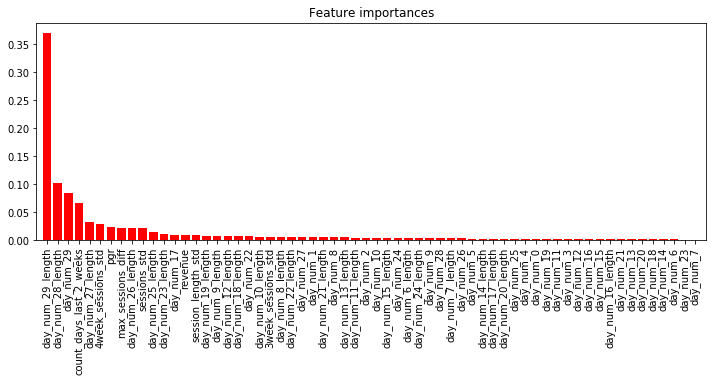

In [35]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Top 10 features:")
for f in range(10):
    print("%d. %s (%f)" % (f + 1, x_columns[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(12,4))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), np.array(x_columns)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Значащие фичи при смене платформы не изменились. Регрессия:

In [36]:
regr_data = valid_players[valid_players['will_stay'] == 1].drop(['will_stay'], axis=1)

In [42]:
x_columns = regr_data.columns.tolist()[1:31] + regr_data.columns[33:].tolist()
X_train = regr_data[regr_data['first_appearance'] < '2017-03-12'][x_columns].values
y_train = regr_data[regr_data['first_appearance'] < '2017-03-12'][regr_data.columns[32]].values
X_test = regr_data[regr_data['first_appearance'] >= '2017-03-12'][x_columns].values
y_test = regr_data[regr_data['first_appearance'] >= '2017-03-12'][regr_data.columns[32]].values

In [43]:
model = XGBRegressor(max_depth=5, min_child_weight=3, gamma=0.1, learning_rate=0.1, reg_alpha=1e-05, subsample=1,
                     colsample_bytree=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('MAE: %0.4f\nr2: %0.4f\nRMSE: %0.4f' % (mean_absolute_error(pred, y_test), r2_score(y_test, pred),
                                              np.sqrt(mean_squared_error(y_test, pred))))

MAE: 2.5346
r2: 0.4079
RMSE: 3.1774


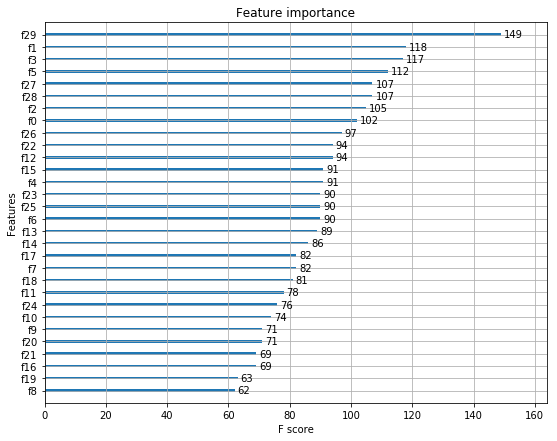

In [41]:
from xgboost import plot_importance
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(9, 7)

Фичи важны те же, однако качество хуже. Это связано с тем, что в играх на android другая аудитория с другой моделью поведения.

# Еще одна задача

Задача - среди тех людей, которые заходили в игру в последние две недели и прошли как минимум 2 игровых кластера, предсказать, кто из них проведет в игре как минимум 3 дня в следующие две недели, а кто нет. В этой задаче рассматриваются только люди, освоившие базовый игровой функционал, так что отвал должен быть меньше.

In [12]:
data = pd.read_csv('practice_sessions_ios.csv', sep='|', names=['id', 'session_number', 'session_length',
                                                                'session_start_time', 'session_end_time', 'actdate'])
data['actdate'] = pd.to_datetime(data['actdate'])

In [13]:
pact = pd.read_csv('practice_pact_ios.csv', sep='|', names=['id', 'actdate', 'regdate', 'clusters_ml_ended', 'revenue',
                        'transactions', 'quests_end', 'm_quests_end', 'crystals_value_spend', 'store_enters'])
pact['actdate'] = pd.to_datetime(pact['actdate'])

1. **Количество дней, проведенных в игре**, говорит о приверженности игрока. Даже если совершаемые им сессии коротки, регулярные визиты говорят о хорошем уровне лояльности.
2. **Количество сессий в день**  - еще один важный показатель. Человек может заходить раз в день и со временем просто забыть про игру, в то время как большее число визитов за день говорит о повышенном уровне интереса.
3. Высокое значение признака **максимальная длина сессии** может говорить о том, что даже во время ожидания восстановления/постройки некий игровых элементов игрок предпочитает оставаться в игре. Также был добавлен признак **средняя длина сессии**.
4. Если в течение двух недель показатели активности игрока имели тенденцию к затуханию, он с меньшей вероятностью останется в игре, поэтому срок в две недели был разбит на **два отрезка по неделе**, после чего были замерены **отношения** следующих величин, агрегированных по последней неделе и всему сроку: **общее количество сессий, медиана, среднее квадратическое и максимальное значение длины сессий, медианное и среднее значение средней длины сессий по дням**.
5. **Количество pgr-сообщений**.

In [10]:
def get_data(observed_date):
    observed_datetime = datetime.strptime(observed_date, '%Y-%m-%d')
    period_beginning = (observed_datetime - timedelta(days=14)).strftime('%Y-%m-%d')
    target_end = (observed_datetime + timedelta(days=14)).strftime('%Y-%m-%d')
    ids = np.unique(pact[((pact['actdate'] < observed_date) & (pact['actdate'] >= period_beginning)) & (pact['clusters_ml_ended'] > 1)][['id']].values.reshape(-1))
    data_ids = data[data['id'].isin(ids)]
    
    recent_players = data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= period_beginning))]
    #count_sessions feature
    sessions_per_id = recent_players.groupby('id')[['actdate']].count().rename(columns={'actdate':'count_sessions'}).reset_index()
    
    target = data_ids[((data_ids['actdate'] >= observed_date) & (data_ids['actdate'] < target_end))]
    target = target.groupby(['id', 'actdate']).count().rename(columns={'session_length':'count_days'})[['count_days']].reset_index().groupby('id').count()[['count_days']].reset_index()
    
    sessions_per_id = pd.DataFrame(sessions_per_id, columns=['id', 'count_sessions'])
    sessions_per_id = sessions_per_id.merge(first_appearances, on='id', how='left')
    #days_from_reg feature
    sessions_per_id['days_from_reg'] = (observed_datetime - sessions_per_id['first_appearance'])
    sessions_per_id['days_from_reg'] = (sessions_per_id['days_from_reg'] / np.timedelta64(1, 'D')).astype(int)
    sessions_per_id = sessions_per_id.drop('first_appearance', axis=1)
    #days_in_game
    sessions_per_id = sessions_per_id.merge(pd.DataFrame(data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= period_beginning))].groupby('id').actdate.nunique()).reset_index().rename(columns={'actdate':'days_in_game'}), on='id', how='left')
    #avg_session_length
    sessions_per_id = sessions_per_id.merge(data_ids[data_ids['actdate']<observed_date].groupby('id').mean().reset_index()[['id','session_length']].rename(columns={'session_length':'avg_session_length'}), on='id', how='left')
    #sessions_per_day feature
    sessions_per_id = sessions_per_id.merge(data_ids[data_ids['actdate']<observed_datetime].groupby('id').count()[['actdate']].reset_index(), on='id', how='left').rename(columns={'actdate':'sessions_per_day'})
    sessions_per_id['sessions_per_day'] = sessions_per_id['sessions_per_day']/sessions_per_id['days_from_reg']
    #session_length_max
    sessions_per_id = sessions_per_id.merge(data_ids[((data_ids['actdate'] < observed_date))].groupby('id')[['session_length']].max().reset_index().fillna(0).rename(columns={'session_length':'max_session_length'}), on='id', how='left')
    #differences
    tmp = data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= period_beginning))].groupby('id')[['actdate']].count().reset_index().rename(columns={'actdate':'14 days'}).merge(data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= (observed_datetime - timedelta(days=7)).strftime('%Y-%m-%d')))].groupby('id')[['actdate']].count().reset_index().rename(columns={'actdate':'7 days'}), on='id', how='left')
    tmp['7/14 diff count_sessions'] = tmp['7 days']/tmp['14 days']
    sessions_per_id = sessions_per_id.merge(tmp[['id', '7/14 diff count_sessions']], on='id', how='left')
    #
    tmp = data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= period_beginning))].groupby('id')[['session_length']].median().reset_index().rename(columns={'session_length':'session_length_median_14 days'}).merge(data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= (observed_datetime - timedelta(days=7)).strftime('%Y-%m-%d')))].groupby('id')[['session_length']].median().reset_index().rename(columns={'session_length':'session_length_median_7 days'}), on='id', how='left')
    tmp['7/14 diff session_length_median'] = tmp['session_length_median_7 days']/(tmp['session_length_median_14 days']+1)
    sessions_per_id = sessions_per_id.merge(tmp[['id', '7/14 diff session_length_median']], on='id', how='left')
    #
    tmp = data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= period_beginning))].groupby('id')[['session_length']].std().reset_index().rename(columns={'session_length':'session_length_std_14 days'}).merge(data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= (observed_datetime - timedelta(days=7)).strftime('%Y-%m-%d')))].groupby('id')[['session_length']].std().reset_index().rename(columns={'session_length':'session_length_std_7 days'}), on='id', how='left')
    tmp['7/14 diff session_length_std'] = tmp['session_length_std_7 days']/(tmp['session_length_std_14 days']+1)
    sessions_per_id = sessions_per_id.merge(tmp[['id', '7/14 diff session_length_std']], on='id', how='left')
    #
    tmp = data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= period_beginning))].groupby('id')[['session_length']].max().reset_index().rename(columns={'session_length':'session_length_std_14 days'}).merge(data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= (observed_datetime - timedelta(days=7)).strftime('%Y-%m-%d')))].groupby('id')[['session_length']].max().reset_index().rename(columns={'session_length':'session_length_std_7 days'}), on='id', how='left')
    tmp['7/14 diff session_length_max'] = tmp['session_length_std_7 days']/(tmp['session_length_std_14 days']+1)
    sessions_per_id = sessions_per_id.merge(tmp[['id', '7/14 diff session_length_max']], on='id', how='left')
    #
    tmp = data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= period_beginning))].groupby(['id', 'actdate']).count()[['session_length']].reset_index().groupby('id')[['session_length']].std().rename(columns={'session_length':'std_sessions_per_day_14'}).reset_index().merge(data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= (observed_datetime - timedelta(days=7)).strftime('%Y-%m-%d')))].groupby(['id', 'actdate']).count()[['session_length']].reset_index().groupby('id')[['session_length']].std().rename(columns={'session_length':'std_sessions_per_day_7'}).reset_index(), on='id', how='left')
    tmp['7/14 diff session_per_day_std'] = tmp['std_sessions_per_day_7']/(tmp['std_sessions_per_day_14']+1)
    sessions_per_id = sessions_per_id.merge(tmp[['id', '7/14 diff session_per_day_std']], on='id', how='left')
    #
    tmp = data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= period_beginning))].groupby(['id', 'actdate']).count()[['session_length']].reset_index().groupby('id')[['session_length']].mean().rename(columns={'session_length':'std_sessions_per_day_14'}).reset_index().merge(data_ids[((data_ids['actdate'] < observed_date) & (data_ids['actdate'] >= (observed_datetime - timedelta(days=7)).strftime('%Y-%m-%d')))].groupby(['id', 'actdate']).count()[['session_length']].reset_index().groupby('id')[['session_length']].mean().rename(columns={'session_length':'std_sessions_per_day_7'}).reset_index(), on='id', how='left')
    tmp['7/14 diff session_per_day_mean'] = tmp['std_sessions_per_day_7']/(tmp['std_sessions_per_day_14']+1)
    sessions_per_id = sessions_per_id.merge(tmp[['id', '7/14 diff session_per_day_mean']], on='id', how='left')
    #
    sessions_per_id = sessions_per_id.merge(dau[((dau['actdate'] < observed_date) & (dau['actdate'] >= period_beginning))][['id','pgr']].groupby('id').sum().reset_index(), on='id', how='left')
    #
    sessions_per_id = sessions_per_id.merge(target, on='id', how='left').fillna(0)
    sessions_per_id['will_stay'] = (sessions_per_id['count_days'] > 2)
    
    return sessions_per_id.fillna(0)

In [47]:
train_dates = ['2017-01-15', '2017-02-15', '2017-03-15']
train_data = pd.DataFrame()
for date in train_dates:
    sess_per_id_tmp = get_data(date)
    train_data = train_data.append(sess_per_id_tmp.fillna(0))
    
test_dates = ['2017-04-15', '2017-05-15']
test_data = pd.DataFrame()
for date in test_dates:
    sess_per_id_tmp = get_data(date)
    test_data = test_data.append(sess_per_id_tmp.fillna(0))

In [48]:
x_columns = train_data.columns[1:-2]
X_train = train_data[x_columns].values
y_train = train_data[train_data.columns[-1]].values
X_test = test_data[x_columns].values
y_test = test_data[test_data.columns[-1]].values

Классифицируем:

In [24]:
from sklearn.model_selection import GridSearchCV
param_grid_xgcl_1 = {
    'n_estimators':[50,100,200,500,1000],
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gr = GridSearchCV(XGBClassifier(), param_grid_xgcl_1, scoring='accuracy')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50}


In [314]:
param_grid_xgcl_2 = {
    'gamma':[i/10.0 for i in range(0,5)],
    'learning_rate': [i/10.0 for i in range(1,5)],
    'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 10, 100]
}
gr = GridSearchCV(XGBClassifier(min_child_weight=3, n_estimators=100, max_depth=3), param_grid_xgcl_2, scoring='f1_macro')
gr.fit(X_train, y_train)
print('Best parameters found by grid search are:', gr.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.2, 'reg_alpha': 10, 'gamma': 0.3}


In [49]:
from xgboost import XGBClassifier
model = XGBClassifier(min_child_weight=3, n_estimators=100, max_depth=3, reg_alpha=10, learning_rate=0.2, gamma=0.3)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
target_names = ["Won't stay", "Will stay"]
print(classification_report(y_test, pred, target_names=target_names))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))
print('accuracy:\n', accuracy_score(y_test, pred))

             precision    recall  f1-score   support

 Won't stay       0.90      0.89      0.90     30776
  Will stay       0.83      0.84      0.83     19178

avg / total       0.87      0.87      0.87     49954

Confusion matrix:
 [[27499  3277]
 [ 3119 16059]]
accuracy:
 0.871962205229


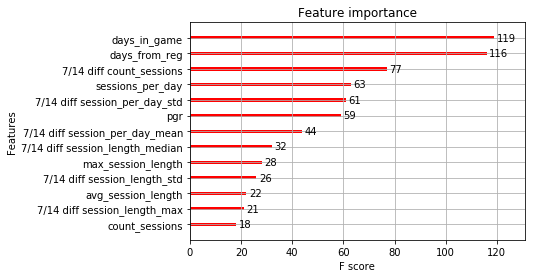

In [54]:
fig=plt.figure(figsize=(3,15))
model.booster().get_fscore()
mapper = {'f{0}'.format(i): v for i, v in enumerate(x_columns)}
mapped = {mapper[k]: v for k, v in model.booster().get_fscore().items()}
plot_importance(mapped, color='red')

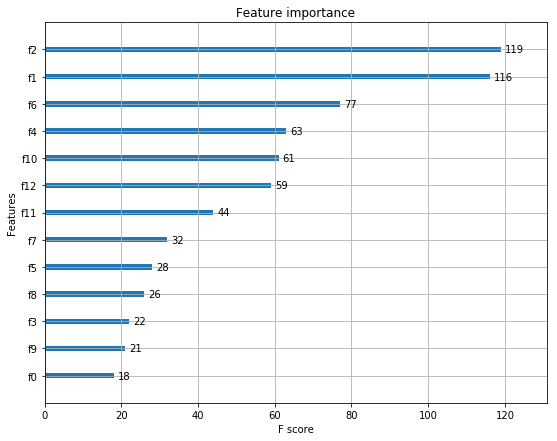

In [30]:
from xgboost import plot_importance
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(9, 7)

f0 - count_sessions
f1 - days_from_reg
f2 - days_in_game
f3 - avg_session_length
f4 - sessions_per_day
f5 - max_session_length
f6 - 7/14 diff count_sessions
f7 - 7/14 diff session_length_median
f8 - 7/14 diff session_length_std
f9 - 7/14 diff session_length_max
f10 - 7/14 diff session_per_day_std
f11 - 7/14 diff session_per_day_mean
f12 - pgr


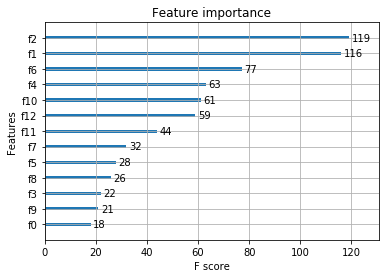

In [55]:
from xgboost import plot_importance
print('\n'.join('f%d - %s' % (c, column) for c, column in enumerate(x_columns)))
plot_importance(model)

Как видно, два признака - количество дней, проведенных в игре за последние 2 недели, и порядковый номер дня после регистрации оказались значительно более важными, чем прочие.

**Сравнение с android**

In [2]:
data = pd.read_csv('practice_sessions_and.csv', sep='|', names=['id', 'session_number', 'session_length',
                                                                'session_start_time', 'session_end_time', 'actdate'])
data['actdate'] = pd.to_datetime(data['actdate'])

In [3]:
import numpy as np
ids = np.random.choice(np.unique(data['id'].values), 1400000, replace=True)

In [4]:
data = data[data['id'].isin(ids)]

In [5]:
pact = pd.read_csv('practice_pact_and.csv', sep='|', names=['id', 'actdate', 'regdate', 'clusters_ml_ended', 'revenue',
                        'transactions', 'quests_end', 'm_quests_end', 'crystals_value_spend', 'store_enters'])
pact = pact[pact['id'].isin(ids)]
pact['actdate'] = pd.to_datetime(pact['actdate'])

In [8]:
dau = pd.read_csv('practice_dau_ios.csv', sep='|', names=['id', 'country', 'pgr', 'actdate'])
dau = dau[dau['id'].isin(ids)]
dau['actdate'] = pd.to_datetime(dau['actdate'])
dau = dau.merge(first_appearances, on='id', how='left')

In [7]:
first_appearances = data[['id', 'actdate']].sort_values('actdate').groupby(['id']).first().reset_index()
first_appearances.columns = ['id', 'first_appearance']

In [11]:
from datetime import datetime, timedelta
train_dates = ['2017-01-15', '2017-02-15', '2017-03-15']
train_data = pd.DataFrame()
for date in train_dates:
    sess_per_id_tmp = get_data(date)
    train_data = train_data.append(sess_per_id_tmp.fillna(0))
    
test_dates = ['2017-04-15', '2017-05-15']
test_data = pd.DataFrame()
for date in test_dates:
    sess_per_id_tmp = get_data(date)
    test_data = test_data.append(sess_per_id_tmp.fillna(0))

In [12]:
x_columns = train_data.columns[1:-2]
X_train = train_data[x_columns].values
y_train = train_data[train_data.columns[-1]].values
X_test = test_data[x_columns].values
y_test = test_data[test_data.columns[-1]].values

In [13]:
from xgboost import XGBClassifier
model = XGBClassifier(min_child_weight=3, n_estimators=100, max_depth=3, reg_alpha=10, learning_rate=0.2, gamma=0.3)
model.fit(X_train, y_train)
pred = model.predict(X_test)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
target_names = ["Won't stay", "Will stay"]
print(classification_report(y_test, pred, target_names=target_names))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))
print('accuracy:\n', accuracy_score(y_test, pred))

             precision    recall  f1-score   support

 Won't stay       0.90      0.93      0.92     65437
  Will stay       0.82      0.77      0.80     27832

avg / total       0.88      0.88      0.88     93269

Confusion matrix:
 [[60780  4657]
 [ 6385 21447]]
accuracy:
 0.881611253471
